In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn import model_selection
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

In [4]:
"""
Read in datasets and convert the datetime index to have a conformed dimension

"""

solar_prod = pd.read_csv('/Users/michaelyacobucci/Desktop/capstone/2015contest_CSV/solararray_production.csv')
solar_prod['Datetime'] = solar_prod.Date + ' ' + (solar_prod.Hour-1).astype(str) + ':00:00'
solar_prod['Datetime'] = pd.to_datetime(solar_prod.Datetime)#, format='%x %X')
solar_prod = solar_prod.set_index('Datetime')
solar_prod.drop(['Date','Hour'],axis=1,inplace=True)
solar_prod = solar_prod.resample('H').max()
#solar_prod.sort_index(inplace=True)


solar_elev = pd.read_csv('/Users/michaelyacobucci/Desktop/capstone/2015contest_CSV/solararray_solarangle.csv')
solar_elev['Datetime'] = solar_elev.Year.astype(str) +'/'+ \
                         solar_elev.Month.astype(str) +'/'+ \
                         solar_elev.Day.astype(str) +' '+ \
                         (solar_elev.Hour - 1).astype(str) +':00:00'
                        
solar_elev['Datetime'] = pd.to_datetime(solar_elev.Datetime)#, format='%x %X')
solar_elev = solar_elev.set_index('Datetime')
solar_elev.drop(['Location','Year', 'Month', 'Day','Hour'],axis=1,inplace=True)
solar_elev = solar_elev.resample('H').max() #double duty of removing the duplicated records
solar_elev.drop(solar_elev[solar_elev.index.min():solar_prod.index.min()].index, inplace = True)


solar_weat = pd.read_csv('/Users/michaelyacobucci/Desktop/capstone/2015contest_CSV/solararray_weather.csv')
solar_weat['Datetime'] = solar_weat.Year.astype(str) +'/'+ \
                         solar_weat.Month.astype(str) +'/'+ \
                         solar_weat.Day.astype(str) +' '+ \
                         solar_weat.Hour.astype(str) +':00:00'              
solar_weat['Datetime'] = pd.to_datetime(solar_weat.Datetime)#, format='%x %X')
solar_weat = solar_weat.set_index('Datetime')
solar_weat.drop(['Location','Year', 'Month', 'Day','Hour'],axis=1,inplace=True)
solar_weat = solar_weat.resample('H').max()
solar_weat.drop(solar_weat[solar_weat.index.min():solar_prod.index.min()-1].index, inplace = True)
solar_weat.drop(solar_weat[solar_prod.index.max()+1:solar_weat.index.max()].index, inplace = True)

print(solar_prod.index.min(), solar_prod.index.max())
print(solar_elev.index.min(), solar_elev.index.max())
print(solar_weat.index.min(), solar_weat.index.max())
print(len(solar_prod), len(solar_elev), len(solar_weat))



2010-01-04 15:00:00 2014-08-31 19:00:00
2010-01-04 16:00:00 2014-08-31 04:00:00
2010-01-04 15:00:00 2014-08-31 19:00:00
40805 40789 40805


In [145]:
"""
Code to build a single dataframe object for our solar data
Also sets night time KWH to 0
"""

df = pd.concat([solar_prod, solar_elev, solar_weat], axis=1)
print(len(df))
df.rename(columns={"Electricity_KW_HR": "kwh"},inplace=True)
df.rename(str.lower, axis='columns',inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour

#create variables from lagged values
number_lags = 4
# for lag in range(1, number_lags + 1):
#     df['KWH_lag_' + str(lag)] = df.Wind_KWH.shift(lag)  
#     df['Wind_speed_lag_' + str(lag)] = df.Wind_Speed_AT_WINDFARM.shift(lag)
# df['kwh_30day_avg'] = df.Wind_KWH_lag_1.rolling('30D').mean()

#Set KWH to 0 for Night-time hours
night_hours = (df.hour.isin((0,1,2,3,4,5,21,22,23)) | 
               ((df.hour == 6) & (df.month.isin((1,2,3,4,8,9,10,11,12)))) |
               ((df.hour == 7) & (df.month.isin((1,2,10,11,12)))) |
               ((df.hour == 8) & (df.month.isin((1,12)))) |
               ((df.hour == 20) & (df.month.isin((1,2,3,9,10,11,12)))) |
               ((df.hour == 19) & (df.month.isin((1,2,11,12)))) |
               ((df.hour == 18) & (df.month.isin((1,12)))) |
               ((df.hour == 17) & (df.month == 12)))
df.loc[night_hours, 'kwh'] = 0

#Interpolate a few odd hours (with data from the same hour on). Note time change at hours 7 and 17
for h in (6,7,8,9,10,11,12,13,14,15,16,17,18,19,20):
     df.loc[(df.hour==h),'kwh'] = df.loc[(df.hour==h),'kwh'].interpolate()
df.kwh[(df.hour==17) & df.kwh.isna()] = 0 #few NaN at the start, just replacing them with 0

print(df.isna().sum())
# plt.figure(figsize=(10,8))
# sns.heatmap(round(df_scal_impu.corr(),2),cmap='seismic',annot=True);

40805
kwh                         0
solar_elevation            21
cloud_cover_fraction      187
dew_point                 266
humidity_fraction         266
precipitation           12217
pressure                14912
temperature               146
visibility                138
wind_speed                179
year                        0
month                       0
day                         0
hour                        0
dtype: int64


In [57]:
"""
Create a scaled dataframe
Create a dataframe with KNN imputed values
"""

# create a scaled version of the dataset
df_scaled = df.copy()
for c in df_scaled.columns:
    df_scaled[c] = (df[c] - df[c].min()) / (df[c].max() - df[c].min())


def knn_impute(dataframe,columns):
    """Function to use KNN to fill in NaN values
       NOTE: the dataframe should be scaled first.
       Returns a new DataFrame"""
    df = dataframe.copy()
    
    #grab each column
    for column in columns:

        train = df[~df[column].isna()].dropna()
        test = df[df[column].isna()]
        filled = df[column].isna()

        clf = KNeighborsRegressor(3, weights='distance')
        trained_model = clf.fit(train[df.columns.difference([column])], train[column])
        
        # Predict missing values' class
        imputed_values = trained_model.predict(test[df.columns.difference([column])].fillna(0))
        df.loc[filled, column] = imputed_values
        
    return df

#Best KNN values
# precipitation: (3, weights='uniform')

#Not sure what to do with these solar_kwh hours
df_scal_impu = knn_impute(df_scaled,df_scaled.columns[1:10]) #1,2,3,4,7,8,9 # lots of missing : 5,6
#df_scal_impu.isna().sum()

#smooth out the imputed years of 2013 and 2014 for presure
for y in (2013,2014):
    for m in range(1,12):
        df_scal_impu.pressure.loc[(df.year==y) & (df.month==m)] = \
        df_scal_impu.pressure.loc[(df.year==y) & (df.month==m)].rolling('24H').mean()

df_scal_impu['prev_day_kwh'] = df_scal_impu.kwh.shift(24)

In [14]:
?pd.DataFrame.drop

In [319]:
"""
Functions for train/test splits

"""

def train_test_split_non_random(df,percent):
    "returns the first percent % as train and the rest as test "
    X = df.iloc[:,1:]
    y = df.iloc[:,0]
    split = int(len(df)*percent) #32644
    X1, X2 = X[:split], X[split:]
    y1, y2 = y[:split], y[split:]
    print('Persistence Model RMSE:', mean_squared_error(y2, y[split-1:-1])**.5)
    return X1, X2, y1, y2

def train_test_split_entire_days(df,percent):
    "returns the first percent as train and the rest as test "
    
    first_hours = df.index[df.index.hour==0]
    starts = np.random.choice(np.arange(0,len(first_hours)), 
                              int(len(first_hours) * (1-percent)),
                              replace=False)
    test_idx = first_hours[starts]
    for i in range(1,24):
        temp = first_hours[starts] + pd.DateOffset(hours=i)
        test_idx = test_idx.append(temp)
    
    X = df.iloc[:,1:]
    y = df.iloc[:,0]
    
    test_idx = test_idx.sort_values()
    train_idx = X.index.difference(test_idx)

    X1, X2 = X.loc[train_idx], X.loc[test_idx]
    y1, y2 = y.loc[train_idx], y.loc[test_idx]

    return X1, X2, y1, y2

#train_test_split_entire_days(df_scal_impu.dropna(),.8)

#df_scal_impu.kwh = df.kwh
# X1, X2, y1, y2 = train_test_split_non_random(df_scal_impu.dropna(),.8)
# X1, X2, y1, y2 = train_test_split(df_scal_impu.dropna().iloc[:,1:],df_scal_impu.dropna().iloc[:,0],train_size=.8)
X1, X2, y1, y2 = train_test_split_entire_days(df_scal_impu.dropna(),.8)

# A predictions DF to compare different models and track predictions
# created before we drop any records from y2 so as to not loose anything, 
#         and to keep a conformed dimension for later graphs/stats
df_pred = pd.DataFrame(y2)

#remove night hours
for l in X1, X2, y1, y2:
    l.drop(df.index[night_hours],inplace=True,errors='ignore')
    

In [246]:
"""
AdaBoost Model
kfold cross validate
"""

seed = 42
k = 10
kfold = model_selection.KFold(n_splits=k, random_state=seed)
model = AdaBoostRegressor(n_estimators=66, learning_rate=1, random_state=seed,
                          base_estimator=DecisionTreeRegressor(max_depth=3))

results = model_selection.cross_val_score(model, X1, y1, cv=kfold, scoring='neg_mean_squared_error')
#predicts = model_selection.cross_val_predict(model,X1,y1,cv=kfold)
#print(((-results)**.5).mean())
print('Cross-Validated Avg RMSE:', np.average(-results, weights=np.repeat(1,k))**.5)
# (-results)**.5

"""Validate model"""

# ada = model.fit(X1,y1)

# df_pred['ada_yhat'] = pd.DataFrame(ada.predict(X2),index = y2.index)

# # ada.feature_importances_
# print('RMSE train: ', mean_squared_error(y1,ada.predict(X1))**.5)
# print('RMSE TEST: ', mean_squared_error(y2,df_pred.ada_yhat.dropna())**.5)

# # better_hist(resid,10)
# sm.qqplot(y2-df_pred.ada_yhat.dropna(), line='s');

Cross-Validated Avg RMSE: 0.1149007962364717


'Validate model'

RMSE train:  0.006998753289770956
RMSE TEST:  0.12356110469291759


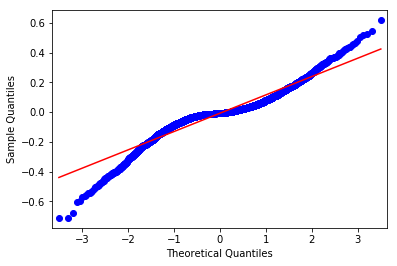

In [320]:
"""Validate model"""

model = AdaBoostRegressor(n_estimators=350, learning_rate=1, random_state=seed,
                          base_estimator=DecisionTreeRegressor(max_depth=30))
ada = model.fit(X1,y1)
df_pred['ada_yhat'] = pd.DataFrame(ada.predict(X2),index = y2.index)

# ada.feature_importances_
print('RMSE train: ', mean_squared_error(y1,ada.predict(X1))**.5)
print('RMSE TEST: ', mean_squared_error(y2,df_pred.ada_yhat.dropna())**.5)

# better_hist(resid,10)
sm.qqplot(y2-df_pred.ada_yhat.dropna(), line='s');

In [321]:
"""Most Important Features"""
pd.DataFrame( [X2.columns, ada.feature_importances_]).T.sort_values(1)

,0,1
4,precipitation,0.00788286
7,visibility,0.0092575
9,year,0.0256461
10,month,0.0274464
8,wind_speed,0.0436375
6,temperature,0.0471606
11,day,0.0481554
2,dew_point,0.0518336
5,pressure,0.0628703
13,prev_day_kwh,0.079466


Datetime
2010    240
2011    281
2012    282
2013    291
2014    256
Name: kwh, dtype: int64
Datetime
2010    196
2011    195
2012    216
2013    196
2014    165
Name: kwh, dtype: int64


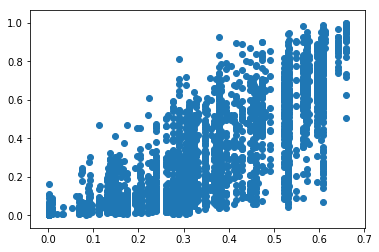

In [1376]:
#don't see any evidence of any years being worse than others
plt.scatter(df_pred.yhat,df_pred.kwh)
print(resid[resid<-.1].groupby(resid[resid<-.1].index.year).count())
print(resid[resid>.1].groupby(resid[resid>.1].index.year).count())

RMSE train:  0.15450947247382646
RMSE TEST:  0.1555567690269699


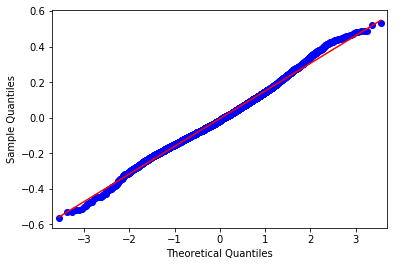

In [314]:
from sklearn.linear_model import LinearRegression

"""Validate model"""

clf = LinearRegression()
lin = clf.fit(X1,y1)
df_pred['lin_yhat'] = pd.DataFrame(lin.predict(X2),index = y2.index)

# ada.feature_importances_
print('RMSE train: ', mean_squared_error(y1,lin.predict(X1))**.5)
print('RMSE TEST: ', mean_squared_error(y2,df_pred.lin_yhat.dropna())**.5)


# better_hist(resid,10)
sm.qqplot(y2-df_pred.lin_yhat.dropna(), line='s');

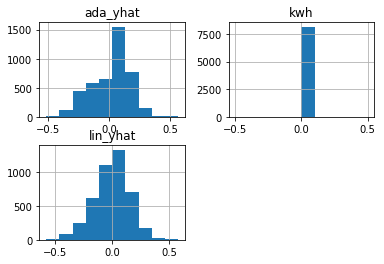

In [267]:
#df_pred.iloc[:,1:] - df_pred.kwh
df_pred.subtract(df_pred.kwh,axis='index').hist();

RMSE train:  0.11397135527435272
RMSE TEST:  0.1290190933414304


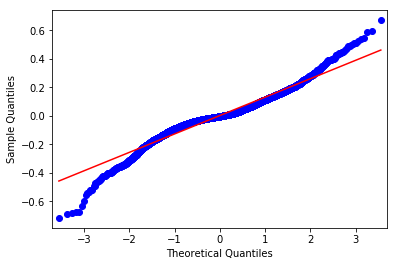

In [315]:
from sklearn.neural_network import MLPRegressor

"""Validate model"""

clf = MLPRegressor(hidden_layer_sizes=(500,250,125),random_state=42)
mlp = clf.fit(X1,y1)
df_pred['mlp_yhat'] = pd.DataFrame(mlp.predict(X2),index = y2.index)

# ada.feature_importances_
print('RMSE train: ', mean_squared_error(y1,mlp.predict(X1))**.5)
print('RMSE TEST: ', mean_squared_error(y2,df_pred.mlp_yhat.dropna())**.5)


# better_hist(resid,10)
sm.qqplot(y2-df_pred.mlp_yhat.dropna(), line='s');

RMSE train:  0.0
RMSE TEST:  0.14384043864570886


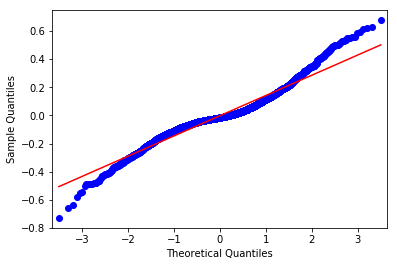

In [180]:
"""Validate model"""

clf = KNeighborsRegressor(11, weights='distance')
knn = clf.fit(X1,y1)
df_pred['knn_yhat'] = pd.DataFrame(knn.predict(X2),index = y2.index)

# ada.feature_importances_
print('RMSE train: ', mean_squared_error(y1,knn.predict(X1))**.5)
print('RMSE TEST: ', mean_squared_error(y2,df_pred.knn_yhat.dropna())**.5)


# better_hist(resid,10)
sm.qqplot(y2-df_pred.knn_yhat.dropna(), line='s');

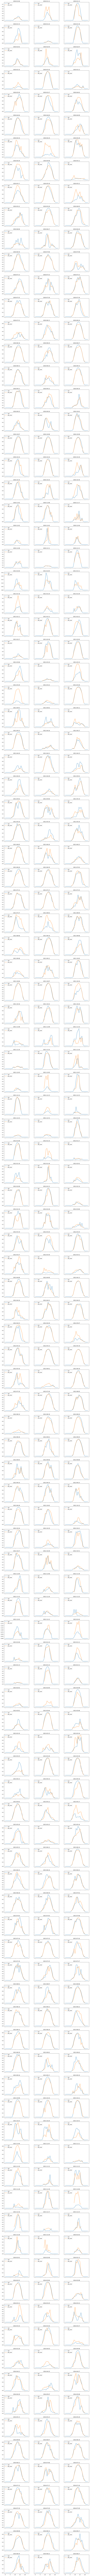

In [322]:
"""
Plot our predictions for each one of our test days.
"""
m = 113
n = 3
fig, ax = plt.subplots(m, n, sharex='col', sharey='row',figsize=(16,500))
# axes are in a two-dimensional array, indexed by [row, col]
idx = np.reshape(np.array(df_pred.index),(int(len(df_pred.index)/24),24))
ix = 0
for i in range(m):
    for j in range(n):
        ax[i, j].plot(df_pred.loc[idx[ix]].reset_index().drop('Datetime',axis=1))
        ax[i, j].set_title(str(df_pred.loc[idx[ix]].index.date[0]))
        ax[i, j].legend(df_pred.columns,loc='upper left')
        ix +=1

fig#.legend(df_pred.columns,loc='upper left')
plt.show();

In [323]:
def over_prediction_stats(df):
    print('--Over Prediction Rate--')
    l = [('Model','Over','%Total', 'Over_KWH_Total', 
          'Avg KWH Over', 'Median Over', '3rd Quantile', 'Largest Over')]
    for i in df.iloc[:,1:].columns:
        over_pred = (df[i] > df.kwh).sum()
        extra_energy = round((df[i] - df.kwh)[df[i] > df.kwh].sum(),3)
        extra_energy_avg = round((df[i] - df.kwh)[df[i] > df.kwh].mean(),3)
        extra_energy_median = round((df[i] - df.kwh)[df[i] > df.kwh].median(),3)
        extra_energy_3rdq= round((df[i] - df.kwh)[df[i] > df.kwh].quantile(.75),3)
        largest = round((df[i] - df.kwh)[df[i] > df.kwh].max(),3)
        l.append((i, over_pred, round(over_pred/len(df.dropna()),3), extra_energy, 
                  extra_energy_avg, extra_energy_median,extra_energy_3rdq, largest))
    
    return pd.DataFrame(l[1:],columns=l[0])

over_prediction_stats(df_pred)

--Over Prediction Rate--


,Model,Over,%Total,Over_KWH_Total,Avg KWH Over,Median Over,3rd Quantile,Largest Over
0,ada_yhat,2481,0.575,185.081,0.075,0.031,0.099,0.711


In [324]:
#df_scaled[c] = (df[c] - df[c].min()) / (df[c].max() - df[c].min())
#df_scaled[c] * (df[c].max() - df[c].min()) = (df[c] - df[c].min())
#(df_scaled[c] * (df[c].max() - df[c].min())) + df[c].min() = df[c] 

df_pred_unscaled = df_pred.copy()
for c in df_pred.columns:
    df_pred_unscaled[c] = (df_pred[c] * (df.kwh.max() - df.kwh.min())) + df.kwh.min()
    
over_prediction_stats(df_pred_unscaled)

--Over Prediction Rate--


,Model,Over,%Total,Over_KWH_Total,Avg KWH Over,Median Over,3rd Quantile,Largest Over
0,ada_yhat,2481,0.575,3.805632e+07,15339.103,6431.92,20306.78,146248.04


In [344]:
df_pred['resid'] = df_pred.kwh - df_pred.ada_yhat

In [353]:
df_pred.resid[df_pred.resid.abs()>.2].count()

460

In [364]:
[ (round(x*.1,1),round((x*.1 * (df.kwh.max() - df.kwh.min())) + df.kwh.min(),1)) for x in range(11)]


[(0.0, 0.0),
 (0.1, 20561.9),
 (0.2, 41123.9),
 (0.3, 61685.8),
 (0.4, 82247.7),
 (0.5, 102809.7),
 (0.6, 123371.6),
 (0.7, 143933.6),
 (0.8, 164495.5),
 (0.9, 185057.4),
 (1.0, 205619.4)]

In [524]:
"""
Convert results to boleans to see accuracy scores
"""
#Test the Accuracy and Precision that our predicted values are greater than the median for that hour.
def unscale_kwh(x):
    return (x * (df.kwh.max() - df.kwh.min())) + df.kwh.min()

df_pred['medians'] = df_scal_impu.groupby(df.index.hour)['kwh'].transform('median')
cutoff = pd.DataFrame(df_scal_impu.groupby(df.index.hour)['kwh'].median())
print(unscale_kwh(cutoff))
df_pred['kwh_bool'] = df_pred.kwh > df_pred.medians
df_pred['yhat_bool'] = df_pred.ada_yhat > df_pred.medians
tp = (df_pred.yhat_bool & df_pred.kwh_bool).sum()
tn = (~df_pred.yhat_bool & ~df_pred.kwh_bool).sum()
fp = (df_pred.yhat_bool & ~df_pred.kwh_bool).sum()
fn = (~df_pred.yhat_bool & df_pred.kwh_bool).sum()
print('Accuracy: ',(tp+tn)/len(df_pred))
print('Precision: ', tp/(tp+fp))
print('  T    F')
print('T',tp,fp)
print('F',fn,tn)
# 90% accuracy on greater than median for the hour
# 80% precsion



                    kwh
Datetime               
0              0.000000
1              0.000000
2              0.000000
3              0.000000
4              0.000000
5              0.000000
6              0.000000
7           2345.624722
8          13484.645112
9          41628.140000
10         73346.350000
11        100647.900000
12        114386.920000
13        115510.340000
14        110938.300000
15         96142.680000
16         69588.660000
17         41054.840000
18         14341.640000
19          3976.678571
20             0.000000
21             0.000000
22             0.000000
23             0.000000
Accuracy:  0.9042527040314651
Precision:  0.8057100482017056
  T    F
T 2173 524
F 255 5184


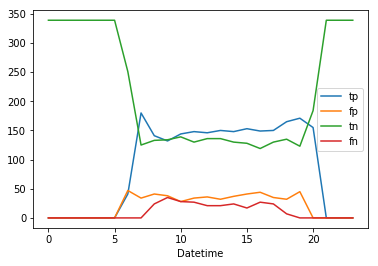

In [529]:
cutoff['tp'] = (df_pred.yhat_bool & df_pred.kwh_bool).groupby(df_pred.index.hour).sum()
cutoff['fp'] = (df_pred.yhat_bool & ~df_pred.kwh_bool).groupby(df_pred.index.hour).sum()
cutoff['tn'] = (~df_pred.yhat_bool & ~df_pred.kwh_bool).groupby(df_pred.index.hour).sum()
cutoff['fn'] = (~df_pred.yhat_bool & df_pred.kwh_bool).groupby(df_pred.index.hour).sum()
cutoff[['tp','fp','tn','fn']].plot();

In [530]:
cutoff

,kwh,tp,fp,tn,fn
Datetime,,,,,
0,0.000000,0.0,0.0,339.0,0.0
1,0.000000,0.0,0.0,339.0,0.0
2,0.000000,0.0,0.0,339.0,0.0
3,0.000000,0.0,0.0,339.0,0.0
4,0.000000,0.0,0.0,339.0,0.0
5,0.000000,0.0,0.0,339.0,0.0
6,0.000000,41.0,47.0,251.0,0.0
7,0.011408,180.0,34.0,125.0,0.0
8,0.065581,141.0,41.0,133.0,24.0


In [434]:
df.index[df.kwh == df.kwh.max()]

DatetimeIndex(['2011-03-02 13:00:00'], dtype='datetime64[ns]', name='Datetime', freq='H')

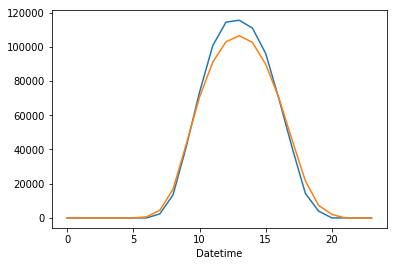

In [489]:
#get the median of each hour
unscale_kwh(df_scal_impu.groupby(df.index.hour)['kwh'].median()).plot()
unscale_kwh(df_scal_impu.groupby(df.index.hour)['kwh'].mean()).plot()